In this notebook, we will make some decisions on which forcing terms that we want to use for our case study and why.


I want to do ssp245 and ssp585

ssp245 is the middle of the road scenario where we expect a radiative forcing of 4.5 W/m^2 by 2100

ssp585 is the extreme top boundary condition where we are still heavily reliant on fossil fuels to develop our economy.

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy

In [2]:
write = False

if write:
    cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(cat_url)
    cmipdf = col.df
    print(cmipdf['experiment_id'].unique())
    data_subset = col.search(table_id="Amon", variable_id = "pr", source_id = ["CanESM5", "HadGEM3-GC31-MM", "GISS-E2-1-H"], experiment_id = ['ssp370'])
    dset_dict = data_subset.to_dataset_dict(zarr_kwargs={'consolidated':True})
    print(dset_dict.keys())
    
    can_dset = dset_dict['ScenarioMIP.CCCma.CanESM5.ssp370.Amon.gn']
    can_bc_dset_45 = can_dset.sel(lon = slice(225.,239.0625), lat = slice(48.835241, 59.99702))
    
    
    had_dset = dset_dict['ScenarioMIP.MOHC.HadGEM3-GC31-MM.ssp126.Amon.gn']
    had_dset = had_dset.sel(lon = slice(225.4, 239.6), lat = slice(48.835241, 59.99702))
    
    gis_dset = dset_dict['ScenarioMIP.NASA-GISS.GISS-E2-1-H.ssp370.Amon.gn']
    gis_dset_45 = gis_dset.sel(lon = slice(226.25, 238.75), lat = slice(48.835241, 59.99702))
    

## Re-gridding the data

Use the code from the re-grid notebook

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import os
fp = r"C:\Users\13432\miniconda3\envs\a448\Library\lib\esmf.mk"
os.environ['ESMFMKFILE'] = fp
import xesmf as xe
import cartopy

In [4]:
can_dset = xr.open_dataset('can_bc_dset.nc')
ds_output = xr.Dataset(
    {
        'lat': (['lat'], can_dset.lat.to_numpy(), {'units': 'degrees_north'}),
        'lon': (['lon'], can_dset.lon.to_numpy(), {'units': 'degrees_east'}),
    }
)

ds_output

<xarray.Dataset> Size: 72B
Dimensions:  (lat: 3, lon: 6)
Coordinates:
  * lat      (lat) float64 24B 51.63 54.42 57.21
  * lon      (lon) float64 48B 225.0 227.8 230.6 233.4 236.2 239.1
Data variables:
    *empty*

In [5]:
# regridder = xe.Regridder(gis_dset_45, ds_output, "conservative")
# gis_45 = regridder(gis_dset_45.pr, keep_attrs=True)

## Write them to file

In [6]:
write = False
if write:
    regridder = xe.Regridder(had_dset, ds_output, "conservative")
    had_out = regridder(had_dset.pr, keep_attrs=True)
    regridder = xe.Regridder(gis_dset_45, ds_output, "conservative")
    gis_45 = regridder(gis_dset_45.pr, keep_attrs=True)
    # had_out.load().to_netcdf('had_26.nc')
    gis_45.load().to_netcdf('gis_70.nc')
    can_bc_dset_45.load().to_netcdf('can_70.nc')

## Plotting line data for the models

### ssp585

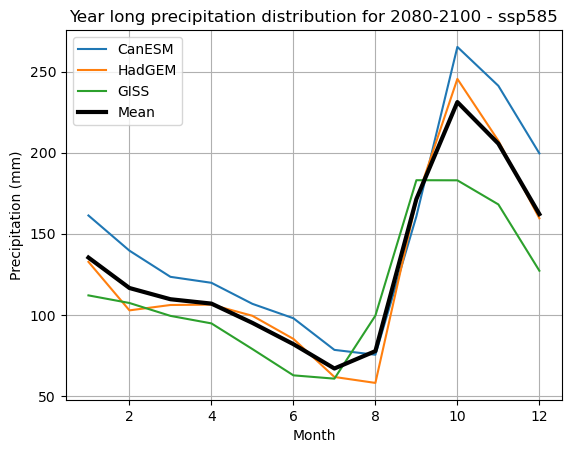

In [7]:
can_85 = xr.open_dataset('can_85.nc')
had_85 = xr.open_dataset('had_85.nc')
gis_85 = xr.open_dataset('gis_85.nc')

can_85_year = can_85.sel(time=slice('2080', '2100'))
had_85_year = had_85.sel(time=slice('2080', '2100'))
gis_85_year = gis_85.sel(time=slice('2080', '2100'))

can_85_map = can_85_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
had_85_map = had_85_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
gis_85_map = gis_85_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4

can_85_map = can_85_map.mean('member_id')
had_85_map = had_85_map.mean('member_id')
gis_85_map = gis_85_map.mean('member_id')

time = can_85_map.month
fig, axs = plt.subplots(1, 1)
mean_85 = (can_85_map.pr+had_85_map.pr+gis_85_map.pr)/3
axs.plot(time,can_85_map.pr, label='CanESM')
axs.plot(time, had_85_map.pr, label='HadGEM')
axs.plot(time, gis_85_map.pr, label='GISS')
axs.plot(time, mean_85, label='Mean', color='k', linewidth=3)
axs.set_xlabel('Month')
axs.set_ylabel('Precipitation (mm)')
axs.set_title('Year long precipitation distribution for 2080-2100 - ssp585')
axs.legend()
axs.grid()

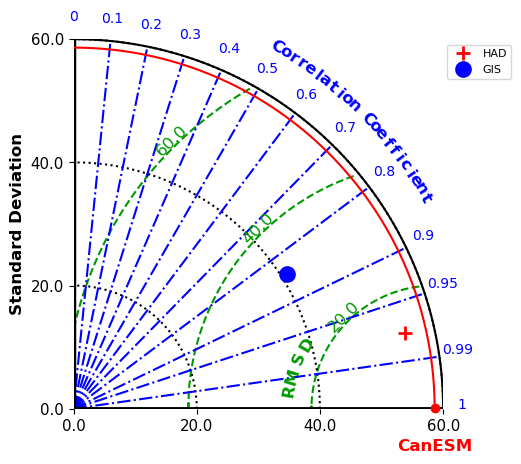

In [8]:
### Monthly correlation
import skill_metrics as sm
import numpy as np

ref = can_85_map.pr.to_numpy().flatten()
can = ref
had = had_85_map.pr.to_numpy().flatten()
gis = gis_85_map.pr.to_numpy().flatten()

data = {'ref': ref, 'can': can, 'had': had, 'gis':gis}

taylor_stats1 = sm.taylor_statistics(data['had'], data['ref'], 'data')
taylor_stats2 = sm.taylor_statistics(data['gis'], data['ref'], 'data')


sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                 taylor_stats2['sdev'][1]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                  taylor_stats2['crmsd'][1]])
ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                  taylor_stats2['ccoef'][1]])

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Non-Dimensional Observation', 'HAD', 'GIS']

'''
Produce the Taylor diagram

Display the data points for correlations that vary from -1 to 1 (2
panels). Label the points and change the axis options for SDEV, CRMSD,
and CCOEF. Increase the upper limit for the SDEV axis and rotate the
CRMSD contour labels (counter-clockwise from x-axis). Exchange color and
line style choices for SDEV, CRMSD, and CCOEFF variables to show effect.
Increase the line width of all lines.

For an exhaustive list of options to customize your diagram, 
please call the function at a Python command line:
>> taylor_diagram
'''
sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', 
                      colOBS = 'r', markerobs = 'o', 
                      titleOBS = 'CanESM', markerLabel=label, markerLegend='on')

### ssp245

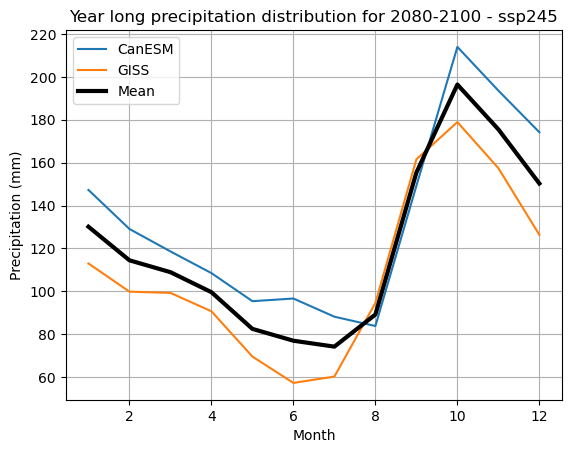

In [9]:
can_45 = xr.open_dataset('can_45.nc')
gis_45 = xr.open_dataset('gis_45.nc')

can_45_year = can_45.sel(time=slice('2080', '2100'))
gis_45_year = gis_45.sel(time=slice('2080', '2100'))

can_45_map = can_45_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
gis_45_map = gis_45_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4

can_45_map = can_45_map.mean('member_id')
gis_45_map = gis_45_map.mean('member_id')

time = can_45_map.month
fig, axs = plt.subplots(1, 1)
mean_45 = (can_45_map.pr+gis_45_map.pr)/2
axs.plot(time,can_45_map.pr, label='CanESM')
axs.plot(time, gis_45_map.pr, label='GISS')
axs.plot(time, mean_45, label='Mean', color='k', linewidth=3)
axs.set_xlabel('Month')
axs.set_ylabel('Precipitation (mm)')
axs.set_title('Year long precipitation distribution for 2080-2100 - ssp245')
axs.legend()
axs.grid()

### ssp126

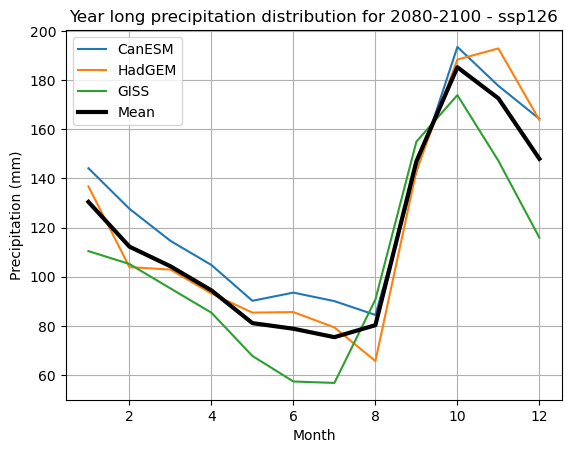

In [10]:
can_26 = xr.open_dataset('can_26.nc')
had_26 = xr.open_dataset('had_26.nc')
gis_26 = xr.open_dataset('gis_26.nc')

can_26_year = can_26.sel(time=slice('2080', '2100'))
had_26_year = had_26.sel(time=slice('2080', '2100'))
gis_26_year = gis_26.sel(time=slice('2080', '2100'))

can_26_map = can_26_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
had_26_map = had_26_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
gis_26_map = gis_26_year.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4

can_26_map = can_26_map.mean('member_id')
had_26_map = had_26_map.mean('member_id')
gis_26_map = gis_26_map.mean('member_id')

time = can_26_map.month
fig, axs = plt.subplots(1, 1)
mean_26 = (can_26_map.pr+had_26_map.pr+gis_26_map.pr)/3
axs.plot(time,can_26_map.pr, label='CanESM')
axs.plot(time, had_26_map.pr, label='HadGEM')
axs.plot(time, gis_26_map.pr, label='GISS')
axs.plot(time, mean_26, label='Mean', color='k', linewidth=3)
axs.set_xlabel('Month')
axs.set_ylabel('Precipitation (mm)')
axs.set_title('Year long precipitation distribution for 2080-2100 - ssp126')
axs.legend()
axs.grid()

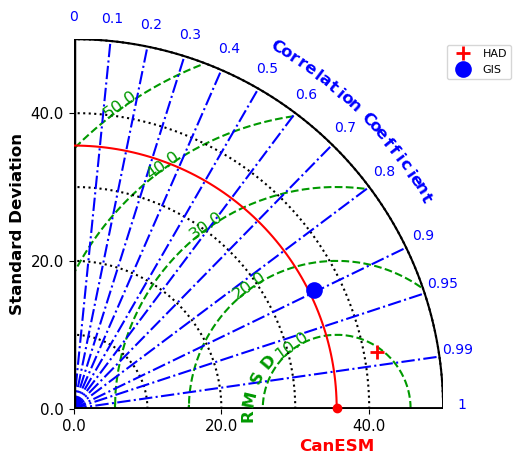

In [11]:
### Monthly correlation
import skill_metrics as sm
import numpy as np

ref = can_26_map.pr.to_numpy().flatten()
had = had_26_map.pr.to_numpy().flatten()
gis = gis_26_map.pr.to_numpy().flatten()

data = {'ref': ref, 'can': can, 'had': had, 'gis':gis}

taylor_stats1 = sm.taylor_statistics(data['had'], data['ref'], 'data')
taylor_stats2 = sm.taylor_statistics(data['gis'], data['ref'], 'data')


sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                 taylor_stats2['sdev'][1]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                  taylor_stats2['crmsd'][1]])
ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                  taylor_stats2['ccoef'][1]])

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Non-Dimensional Observation', 'HAD', 'GIS']

'''
Produce the Taylor diagram

Display the data points for correlations that vary from -1 to 1 (2
panels). Label the points and change the axis options for SDEV, CRMSD,
and CCOEF. Increase the upper limit for the SDEV axis and rotate the
CRMSD contour labels (counter-clockwise from x-axis). Exchange color and
line style choices for SDEV, CRMSD, and CCOEFF variables to show effect.
Increase the line width of all lines.

For an exhaustive list of options to customize your diagram, 
please call the function at a Python command line:
>> taylor_diagram
'''
sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', 
                      colOBS = 'r', markerobs = 'o', 
                      titleOBS = 'CanESM', markerLabel=label, markerLegend='on')

### ssp370

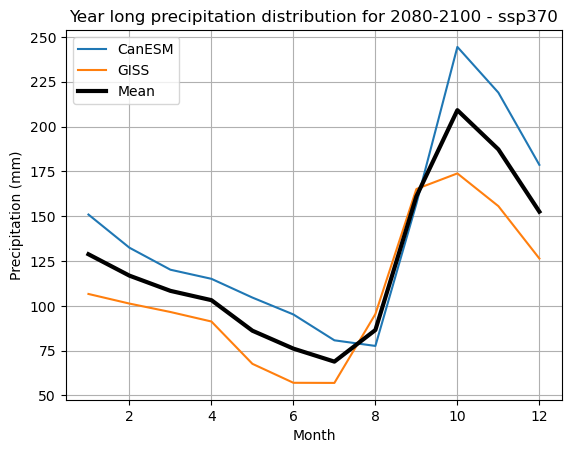

In [12]:
can_70 = xr.open_dataset('can_70.nc')
gis_70 = xr.open_dataset('gis_70.nc')

can_70 = can_70.sel(time=slice('2080', '2100'))
gis_70 = gis_70.sel(time=slice('2080', '2100'))

can_70_map = can_70.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
gis_70_map = gis_70.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4

can_70_map = can_70_map.mean('member_id')
gis_70_map = gis_70_map.mean('member_id')

time = can_70_map.month
fig, axs = plt.subplots(1, 1)
mean_70 = (can_70_map.pr+gis_70_map.pr)/2
axs.plot(time,can_70_map.pr, label='CanESM')
axs.plot(time, gis_70_map.pr, label='GISS')
axs.plot(time, mean_70, label='Mean', color='k', linewidth=3)
axs.set_xlabel('Month')
axs.set_ylabel('Precipitation (mm)')
axs.set_title('Year long precipitation distribution for 2080-2100 - ssp370')
axs.legend()
axs.grid()

## All scenarios combined and averaged in line plot

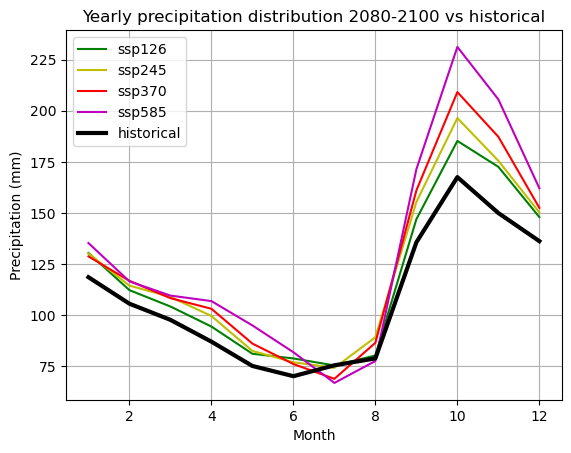

In [13]:
can_bc_dset = xr.open_dataset('can_bc_dset.nc')
had_bc_dset = xr.open_dataset('had_regrid.nc')
gis_bc_dset = xr.open_dataset('gis_regrid.nc')

can_20 = can_bc_dset.sel(time=slice('2001', '2010'))
had_20 = had_bc_dset.sel(time=slice('2001', '2010'))
gis_20 = gis_bc_dset.sel(time=slice('2001', '2010'))

can_20 = can_20.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
had_20 = had_20.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4
gis_20 = gis_20.groupby('time.month').mean('time').mean(['lon', 'lat'])*86400*30.4

can_20 = can_20.mean('member_id')
had_20 = had_20.mean('member_id')
gis_20 = gis_20.mean('member_id')

mean_20 = (can_20.pr+had_20.pr+gis_20.pr)/3


fig, axs = plt.subplots(1, 1)
axs.plot(time,mean_26, label='ssp126', color='g')
axs.plot(time, mean_45, label='ssp245', color='y')
axs.plot(time, mean_70, label='ssp370', color='r')
axs.plot(time, mean_85, label='ssp585', color='m')
axs.plot(time, mean_20, label='historical', linewidth = 3, color='k')
axs.set_xlabel('Month')
axs.set_ylabel('Precipitation (mm)')
axs.set_title('Yearly precipitation distribution 2080-2100 vs historical')
axs.legend()
axs.grid()

## Creating maps to show the distance away from the mean

Will do this for both warm and cold months

In [22]:
## Start by creating plots for warm months

# Need the historical mean first, so start working on that first

can_year_hist = can_bc_dset.sel(time=slice('2001', '2010'))
had_year_hist = had_bc_dset.sel(time=slice('2001', '2010'))
gis_year_hist = gis_bc_dset.sel(time=slice('2001', '2010'))

can_year_hist = can_year_hist.groupby('time.month').mean('time')*86400*30.4
had_year_hist = had_year_hist.groupby('time.month').mean('time')*86400*30.4
gis_year_hist = gis_year_hist.groupby('time.month').mean('time')*86400*30.4

can_warm_hist = can_year_hist.sel(month=slice(5,8)).mean('member_id')
had_warm_hist = had_year_hist.sel(month=slice(5,8)).mean('member_id')
gis_warm_hist = gis_year_hist.sel(month=slice(5,8)).mean('member_id')

can_fall_hist = can_year_hist.sel(month=slice(9,12)).mean('member_id')
had_fall_hist = had_year_hist.sel(month=slice(9,12)).mean('member_id')
gis_fall_hist = gis_year_hist.sel(month=slice(9,12)).mean('member_id')

can_cold_hist = can_year_hist.sel(month=slice(1,4)).mean('member_id')
had_cold_hist = had_year_hist.sel(month=slice(1,4)).mean('member_id')
gis_cold_hist = gis_year_hist.sel(month=slice(1,4)).mean('member_id')

# ssp585
can_85_year = can_85.sel(time=slice('2080', '2100'))
had_85_year = had_85.sel(time=slice('2080', '2100'))
gis_85_year = gis_85.sel(time=slice('2080', '2100'))

can_85_year = can_85_year.groupby('time.month').mean('time')*86400*30.4
had_85_year = had_85_year.groupby('time.month').mean('time')*86400*30.4
gis_85_year = gis_85_year.groupby('time.month').mean('time')*86400*30.4

can_warm_85 = can_85_year.sel(month=slice(5,8)).mean('member_id')
had_warm_85 = had_85_year.sel(month=slice(5,8)).mean('member_id')
gis_warm_85 = gis_85_year.sel(month=slice(5,8)).mean('member_id')

can_fall_85 = can_85_year.sel(month=slice(9,12)).mean('member_id')
had_fall_85 = had_85_year.sel(month=slice(9,12)).mean('member_id')
gis_fall_85 = gis_85_year.sel(month=slice(9,12)).mean('member_id')

can_cold_85 = can_85_year.sel(month=slice(1,4)).mean('member_id')
had_cold_85 = had_85_year.sel(month=slice(1,4)).mean('member_id')
gis_cold_85 = gis_85_year.sel(month=slice(1,4)).mean('member_id')

# ssp245
can_45_year = can_45.sel(time=slice('2080', '2100'))
gis_45_year = gis_45.sel(time=slice('2080', '2100'))

can_45_year = can_45.groupby('time.month').mean('time')*86400*30.4
gis_45_year = gis_45.groupby('time.month').mean('time')*86400*30.4

can_warm_45 = can_45_year.sel(month=slice(5,8)).mean('member_id')
gis_warm_45 = gis_45_year.sel(month=slice(5,8)).mean('member_id')

can_fall_45 = can_45_year.sel(month=slice(9,12)).mean('member_id')
gis_fall_45 = gis_45_year.sel(month=slice(9,12)).mean('member_id')

can_cold_45 = can_45_year.sel(month=slice(1,4)).mean('member_id')
gis_cold_45 = gis_45_year.sel(month=slice(1,4)).mean('member_id')

#ssp126
can_26_year = can_26.sel(time=slice('2080', '2100'))
had_26_year = had_26.sel(time=slice('2080', '2100'))
gis_26_year = gis_26.sel(time=slice('2080', '2100'))

can_26_year = can_26_year.groupby('time.month').mean('time')*86400*30.4
had_26_year = had_26_year.groupby('time.month').mean('time')*86400*30.4
gis_26_year = gis_26_year.groupby('time.month').mean('time')*86400*30.4

can_warm_26 = can_26_year.sel(month=slice(5,8)).mean('member_id')
had_warm_26 = had_26_year.sel(month=slice(5,8)).mean('member_id')
gis_warm_26 = gis_26_year.sel(month=slice(5,8)).mean('member_id')

can_fall_26 = can_26_year.sel(month=slice(9,12)).mean('member_id')
had_fall_26 = had_26_year.sel(month=slice(9,12)).mean('member_id')
gis_fall_26 = gis_26_year.sel(month=slice(9,12)).mean('member_id')

can_cold_26 = can_26_year.sel(month=slice(1,4)).mean('member_id')
had_cold_26 = had_26_year.sel(month=slice(1,4)).mean('member_id')
gis_cold_26 = gis_26_year.sel(month=slice(1,4)).mean('member_id')

#ssp370

can_70_year = can_70.groupby('time.month').mean('time')*86400*30.4
gis_70_year = gis_70.groupby('time.month').mean('time')*86400*30.4

can_warm_70 = can_70_year.sel(month=slice(5,8)).mean('member_id')
gis_warm_70 = gis_70_year.sel(month=slice(5,8)).mean('member_id')

can_fall_70 = can_70_year.sel(month=slice(9,12)).mean('member_id')
gis_fall_70 = gis_70_year.sel(month=slice(9,12)).mean('member_id')

can_cold_70 = can_70_year.sel(month=slice(1,4)).mean('member_id')
gis_cold_70 = gis_70_year.sel(month=slice(1,4)).mean('member_id')

## Calculating and plotting warm month differences

In [39]:
## warm month differences 

hist_mean_w = (can_warm_hist+had_warm_hist+gis_warm_hist)/3

model_mean_w_85 = (can_warm_85+had_warm_85+gis_warm_85)/3
difference_w_85 = model_mean_w_85 - hist_mean_w
difference_w_85 = difference_w_85.mean('month')

model_mean_w_45 = (can_warm_45+gis_warm_45)/2
difference_w_45 = model_mean_w_45 - hist_mean_w
difference_w_45 = difference_w_45.mean('month')

model_mean_w_26 = (can_warm_26+had_warm_26+gis_warm_26)/3
difference_w_26 = model_mean_w_26 - hist_mean_w
difference_w_26 = difference_w_26.mean('month')

model_mean_w_70 = (can_warm_70+gis_warm_70)/2
difference_w_70 = model_mean_w_70 - hist_mean_w
difference_w_70 = difference_w_70.mean('month')

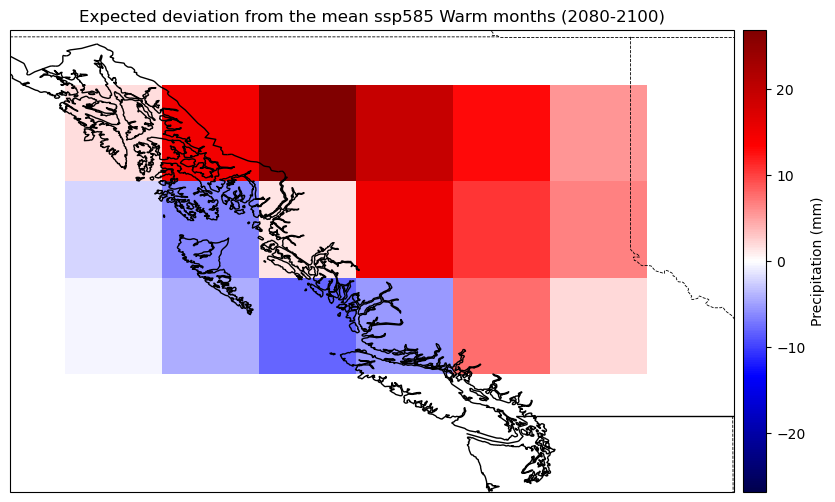

In [38]:
map = difference_w_85

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp585 Warm months (2080-2100)")

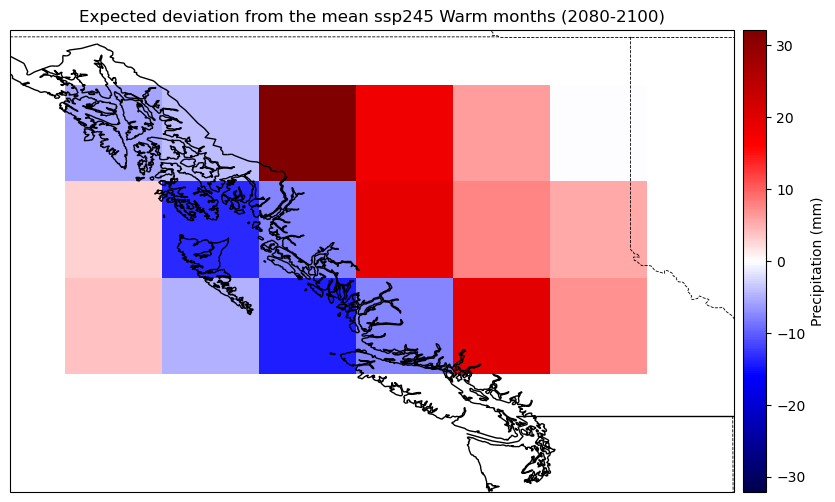

In [43]:
map = difference_w_45

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp245 Warm months (2080-2100)")

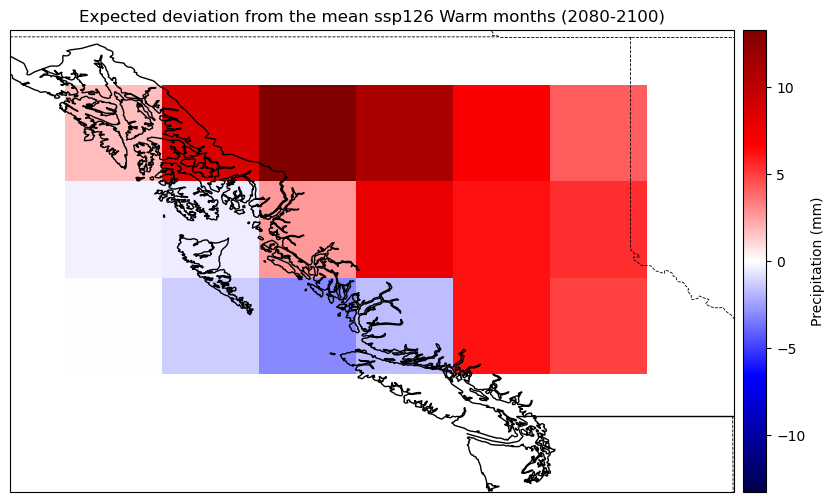

In [42]:
map = difference_w_26

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp126 Warm months (2080-2100)")

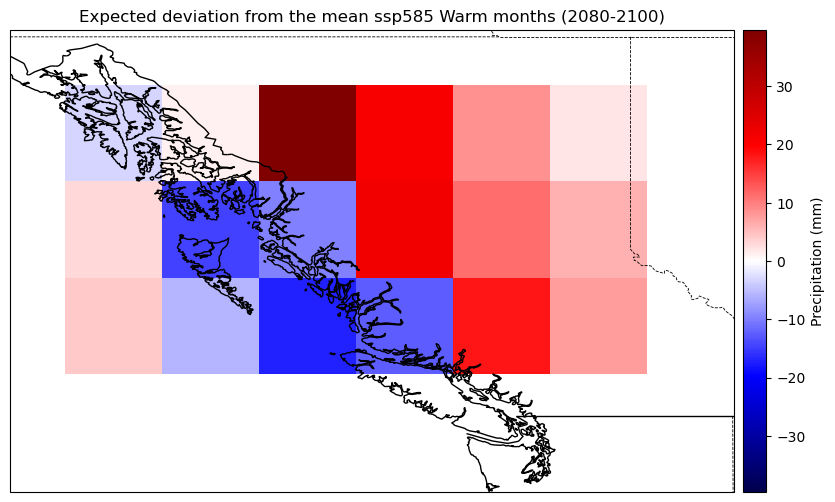

In [44]:
map = difference_w_70

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp585 Warm months (2080-2100)")

## Cold months now

In [45]:
hist_mean_c = (can_cold_hist+had_cold_hist+gis_cold_hist)/3

model_mean_c_85 = (can_cold_85+had_cold_85+gis_cold_85)/3
difference_c_85 = model_mean_c_85 - hist_mean_c
difference_c_85 = difference_c_85.mean('month')

model_mean_c_45 = (can_cold_45+gis_cold_45)/2
difference_c_45 = model_mean_c_45 - hist_mean_c
difference_c_45 = difference_c_45.mean('month')

model_mean_c_26 = (can_cold_26+had_cold_26+gis_cold_26)/3
difference_c_26 = model_mean_c_26 - hist_mean_c
difference_c_26 = difference_c_26.mean('month')

model_mean_c_70 = (can_cold_70+gis_cold_70)/2
difference_c_70 = model_mean_c_70 - hist_mean_c
difference_c_70 = difference_c_70.mean('month')

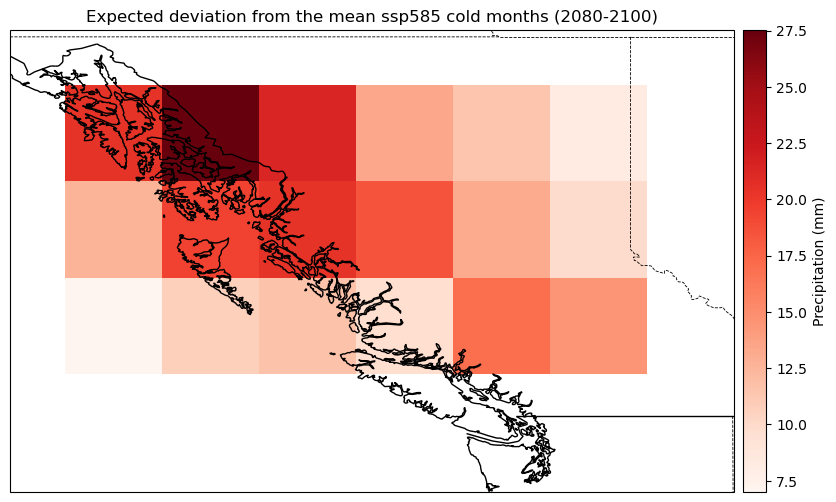

In [57]:
map = difference_c_85

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp585 cold months (2080-2100)")

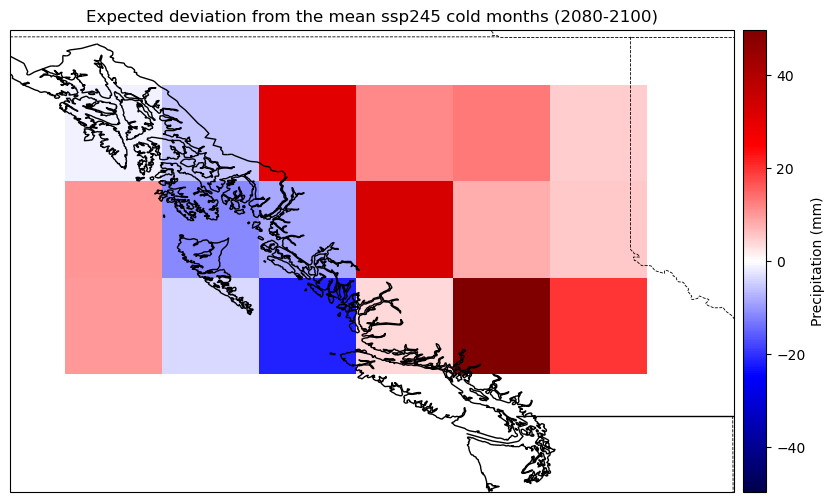

In [56]:
map = difference_c_45

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp245 cold months (2080-2100)")

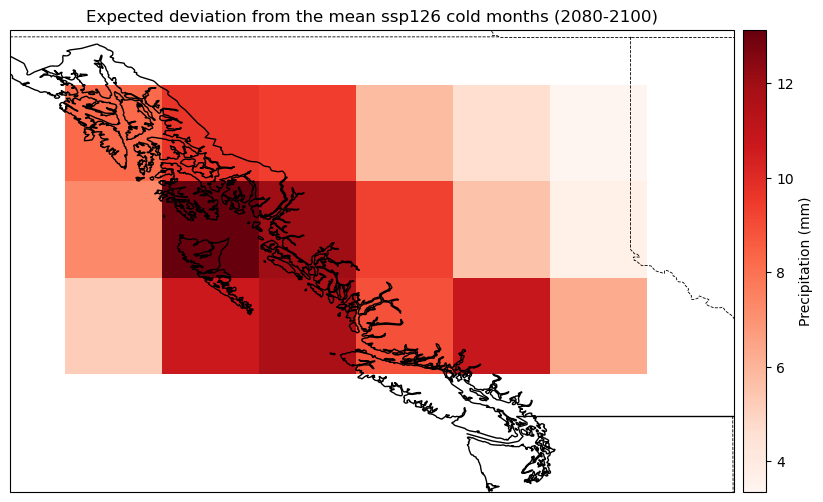

In [55]:
map = difference_c_26

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp126 cold months (2080-2100)")

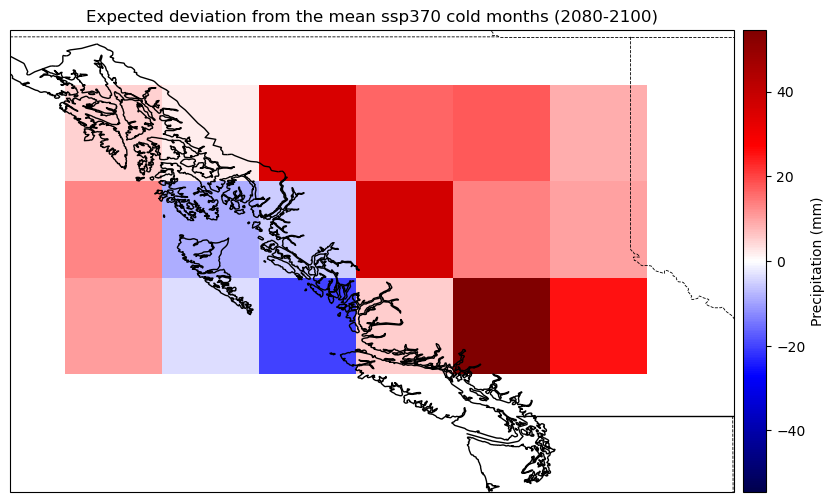

In [54]:
map = difference_c_70

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp370 cold months (2080-2100)")

## Fall months

In [58]:
hist_mean_f = (can_fall_hist+had_fall_hist+gis_fall_hist)/3

model_mean_f_85 = (can_fall_85+had_fall_85+gis_fall_85)/3
difference_f_85 = model_mean_f_85 - hist_mean_f
difference_f_85 = difference_f_85.mean('month')

model_mean_f_45 = (can_fall_45+gis_fall_45)/2
difference_f_45 = model_mean_f_45 - hist_mean_f
difference_f_45 = difference_f_45.mean('month')

model_mean_f_26 = (can_fall_26+had_fall_26+gis_fall_26)/3
difference_f_26 = model_mean_f_26 - hist_mean_f
difference_f_26 = difference_f_26.mean('month')

model_mean_f_70 = (can_fall_70+gis_fall_70)/2
difference_f_70 = model_mean_f_70 - hist_mean_f
difference_f_70 = difference_f_70.mean('month')

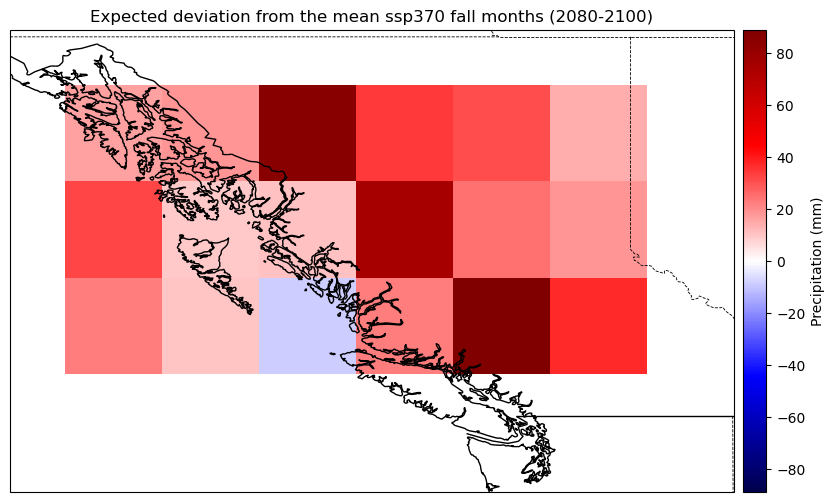

In [60]:
map = difference_f_70

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp370 fall months (2080-2100)")

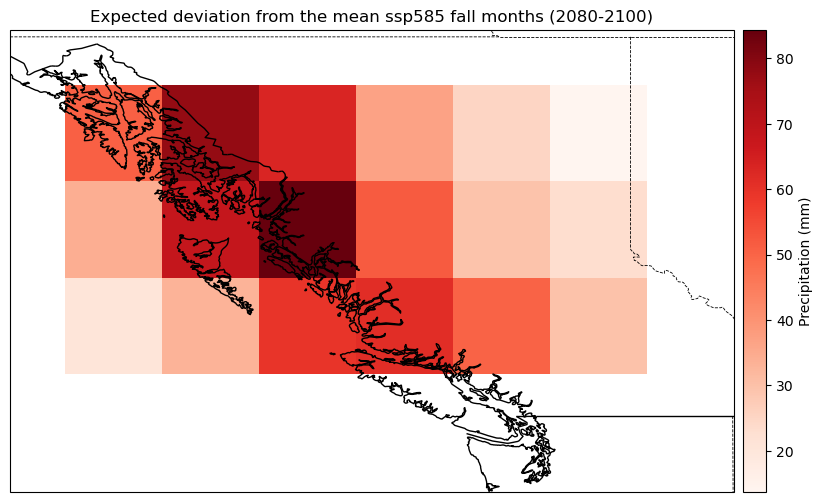

In [62]:
map = difference_f_85

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp585 fall months (2080-2100)")

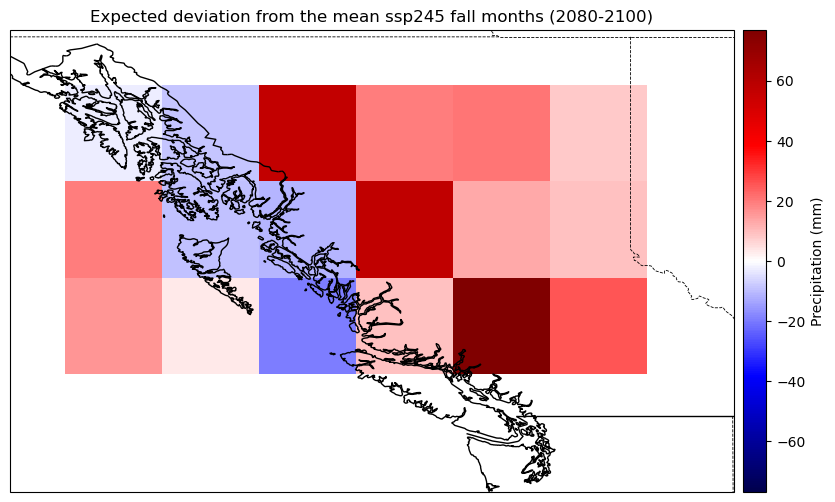

In [63]:
map = difference_f_45

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='seismic', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp245 fall months (2080-2100)")

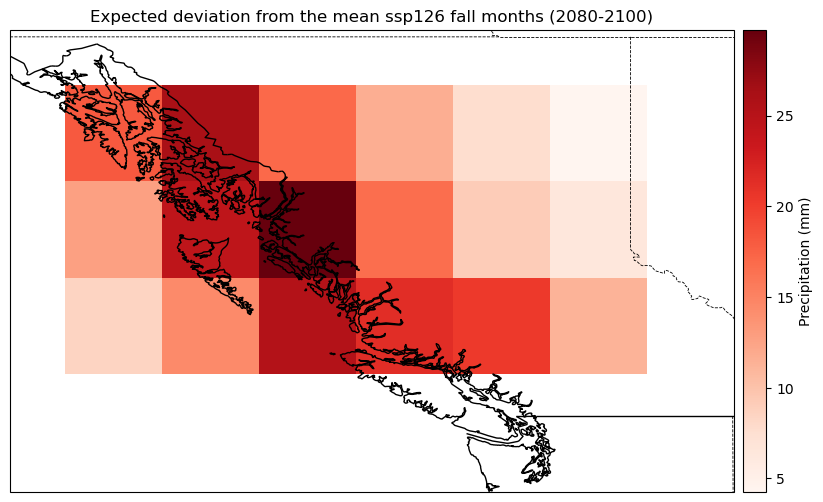

In [65]:
map = difference_f_26

fig = plt.figure(1, figsize=[12,6])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-138, -117, 46.8, 60.2])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

map.pr.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Precipitation (mm)", 'pad':0.01})
ax.title.set_text("Expected deviation from the mean ssp126 fall months (2080-2100)")